# Prediction of cab orders using time series <a class='tocSkip'></a>

The company **Sweet Lift** taxi has collected historical data on cab orders at airports. To attract more drivers during peak hours, we need to predict the number of cab orders for the next hour. In this project I build a model for such a prediction.

The **RMSE** metric in the test set should be no more than 48.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-instructions" data-toc-modified-id="Project-instructions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project instructions</a></span><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Description</a></span></li></ul></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Build-of-characteristics" data-toc-modified-id="Build-of-characteristics-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Build of characteristics</a></span></li><li><span><a href="#Predictive-models" data-toc-modified-id="Predictive-models-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Predictive models</a></span><ul class="toc-item"><li><span><a href="#Lineal-regression" data-toc-modified-id="Lineal-regression-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Lineal regression</a></span></li><li><span><a href="#Regression-tree" data-toc-modified-id="Regression-tree-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Regression tree</a></span></li><li><span><a href="#Random-forest-regressor" data-toc-modified-id="Random-forest-regressor-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Random forest regressor</a></span></li><li><span><a href="#Testing-the-best-model---Random-Forest-Regressor" data-toc-modified-id="Testing-the-best-model---Random-Forest-Regressor-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>Testing the best model - Random Forest Regressor</a></span></li><li><span><a href="#Sanity-test" data-toc-modified-id="Sanity-test-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Sanity test</a></span></li></ul></li><li><span><a href="#Conclusion." data-toc-modified-id="Conclusion.-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Conclusion.</a></span></li></ul></li></ul></div>

# Project instructions

1. Download the data and resample for one hour.
2. Analyze the data
3. Train different models with different hyperparameters. The test sample should be 10% of the initial data set.4. Test the data using the test sample and provide a conclusion.

## Data Description

The data is stored in the `taxi.csv` file. 	
The number of orders is in the `num_orders` column.

# Data preparation

In [1]:
# Libraries

import pandas as pd                                      # DataFrame manipulation
import matplotlib.pyplot as plt                          # Plot
import numpy as np                                       # Numeric array manipulation

from statsmodels.tsa.seasonal import seasonal_decompose  # Sesonality and temporality calculation

from sklearn.linear_model import LinearRegression        # Linear regression
from sklearn.tree import DecisionTreeRegressor           # Decision Tree Regression
from sklearn.ensemble import RandomForestRegressor       # Random Forest regressor
from sklearn.metrics import mean_squared_error           # MSE
from sklearn.model_selection import GridSearchCV         # Model selection 
from sklearn.model_selection import cross_val_score      # Cross validation 
from sklearn.model_selection import train_test_split     # Data subsetting

In [3]:
# Data load
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

# Verify chronological order
print(data.index.is_monotonic)

# DataFrame info
print(data.info())

# DataFrame head
data.head()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


The dataset consists of 26,496 entries of cab orders recorded every 10 minutes between March 1 and August 31, 2018. The data are sorted chronologically. There are no missing values in the dataset.

## Analysis

In this section we will analyze the time series of hourly cab orders and their daily average using the resampling technique and moving average respectively.

The resampled data will be stored in the DataFrame **`taxi_hour`** which shows the number of requested trips per hour (see column `'num_orders'`). The daily (i.e. every 24 hours) average number of trips will be stored in the `'day_mean'` column. 

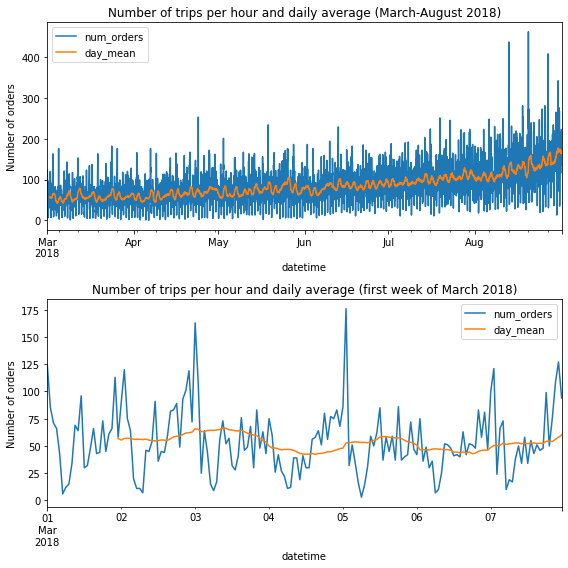

In [4]:
# Daily cab orders
taxi_hour = data.resample('1H').sum()                  # Get orders per hour
taxi_hour['day_mean'] = taxi_hour.rolling(24).mean()   # Get daily mean cab orders

# Plot time series of daily orders and weekly mean
plt.figure(figsize=(8, 8))

plt.subplot(211)
taxi_hour.plot(ax=plt.gca())
plt.title('Number of trips per hour and daily average (March-August 2018)')
plt.ylabel('Number of orders')

plt.subplot(212)
taxi_hour['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Number of trips per hour and daily average (first week of March 2018)')
plt.ylabel('Number of orders')
plt.tight_layout()
plt.show()

Despite the fluctuations observed in the number of daily trips and the weekly average, the time series graph reveals that there is a steady increase in the use of the service offered by **Sweet Lift**.

Let's analyze the trend and seasonality of cab orders requested daily. Using the **`seasonal_descompose()`** function we will obtain and plot the trend and seasonality of the data. The residuals are not plotted as they do not provide valuable information.

The trend will be plotted for the whole analysis period, while the seasonality will be plotted for the whole period and for the first week of March 2018.

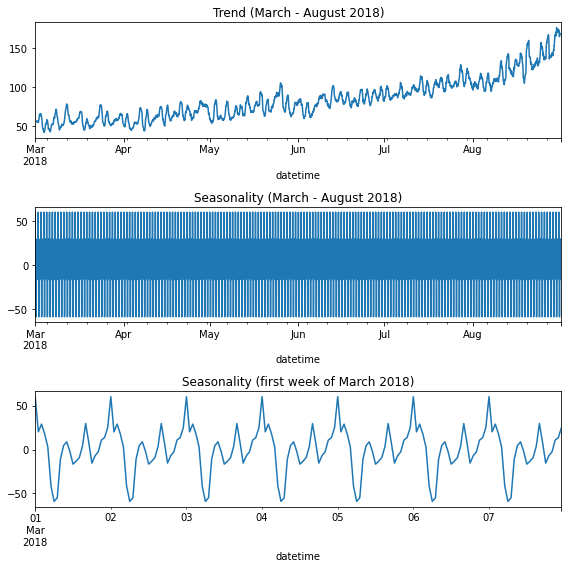

In [5]:
# Trend and seasonality

decomposed = seasonal_decompose(taxi_hour['num_orders'])

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend (March - August 2018)')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality (March - August 2018)')

plt.subplot(313)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonality (first week of March 2018)')
plt.tight_layout()
plt.show()

The trend in our time series data reveals an increase in the number of trips over time. The seasonality of the data shows a cyclical pattern in the number of cab orders. When analyzing the seasonality, it appears that we are dealing with a stationary stochastic process since its distribution does not change over time so it is possible to make a forecasts with the data set.

## Build of characteristics

In this section we are going to create features for a one-step (i.e. one hour) forecast horizon. These features are of three types:

1. Calendar characteristics
    * `month`
    * `day`
    * `dayofweek`: where `0` is Monday and `6` is Sunday
    * `hour`: hour of the order between 00:00 y 23:59
    
2. Phase shift characteristics.
    * The above values in the time series will tell you whether the function `x(t)` will increase or decrease. Let's create 6 features.
    
3. Rolling mean.
    * `rolling_mean`: sets the overall trend of the time series. The rolling mean at _t_ considers the current value of the series _x(t)_, which we do not want because the current value belongs to the target and not to the features. So the moving average is calculated with a shift using the `shift()` function. 
        
To create these features the custom function **`make_features`** will be used with the following arguments:
* `data`: input DataFrame 
* `max_lag`: maximum offset
* `rolling_mean_size`: size of the window over which the moving average is calculated

The function will be applied on the DataFrame **`taxi`** which groups the number of cabs ordered per hour in the analysis period.

Once the features are created, the missing values will be removed.

In [6]:
# Function make_features

def make_features(data, max_lag, rolling_mean_size):
    '''Calendar characteristics'''
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    '''Offset characteristics'''
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    '''Target variable, number of cabs in the next hour.'''
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [7]:
# DataFrame with the number of trips per hour
taxi = data.resample('1H').sum()

# Features creation
make_features(taxi, 6, 6)

# Drop NaNs
taxi.dropna(inplace = True)

# DataFrame head
taxi.head(10)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,65.833333
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,47.166667
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,35.500000
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,29.333333
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,29.833333
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,33.333333
2018-03-01 12:00:00,30,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,48.333333
2018-03-01 13:00:00,32,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,51.333333
2018-03-01 14:00:00,48,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,54.166667


I have added 9 features and our target variable to our DataFrame now I will proceed to create the training and test sets in a 4:1 ratio to train the predictive models.

In [8]:
# Subset creation 
train_valid, test = train_test_split(taxi, shuffle=False, test_size=0.1)

# Division of the training set and validation
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

# Features and Target

# Training subset
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

# Validation subset
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

# Test subset
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

# Subset size
print(f'Training features:      {features_train.shape}')
print(f'Training target:        {target_train.shape}\n')

print(f'Validation features:    {features_valid.shape}')
print(f'Validation target:      {target_valid.shape}\n')

print(f'Test features:          {features_test.shape}')
print(f'Test target :           {target_test.shape}\n')

Training features:      (3572, 11)
Training target:        (3572,)

Validation features:    (397, 11)
Validation target:      (397,)

Test features:          (441, 11)
Test target :           (441,)



## Predictive models

Since the goal of the project is to predict the number of trips in the next hour, we are faced with a regression task with a one-hour horizon. I will train the following regression models and evaluate them according to the RMSE metric:

1. Lineal regression
2. Regression treee
3. Random forest regressor

Recall that the RMSE metric should not exceed 48, so the best model will be the one that is equal to or less than this threshold.

### Lineal regression

In [9]:
# Lineal regression model
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
lr_predict = lr_model.predict(features_valid)
lr_recm = mean_squared_error(target_valid, lr_predict, squared=False)
print(f'Linear regression RMSE: {lr_recm:.2f}')

Linear regression RMSE: 40.54


The linear regression model had a **RMSE of 40.54** over the validation set, this value is below the required RMSE threshold of 48.

### Regression tree

For the development of this model, I will tune the maximum depth hyperparameters (`max_depth`) of the regression tree by iterating values from 1 to 10. The optimal depth will be determined according to the model with the RMSE below the required threshold (_i.e._ 48).

In [10]:
best_ar_model = None
best_ar_recm = 48
best_ar_depth = 0

# Decision tree regressor
for depth in range(1, 11):
    ar_model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    ar_model.fit(features_train, target_train)
    ar_predict = ar_model.predict(features_valid)
    ar_recm = mean_squared_error(target_valid, ar_predict, squared=False)
    
    if ar_recm < best_ar_recm:
        best_ar_model = ar_model
        best_ar_recm = ar_recm
        best_ar_depth = depth

print(f"Decision tree regressor RMSE: {best_ar_recm:.2f}") 
print("Optimal depth:", best_ar_depth)

Decision tree regressor RMSE: 36.31
Optimal depth: 10


The optimal regression tree model has a depth of 10 with a **RECM of 36.31**. This value is lower than that obtained by the linear regression model.

### Random forest regressor

Finally I am going to build a random forest regression model, for which I will look for the best combination between the number of estimators (n_estimators) and the maximum depth of each tree (max_depth). The number of estimators will be iterated between 10 and 50 with step of 10 (10, 20, 30, 40 and 50), the maximum depth will be iterated from 1 to 10. The optimal model will be the one with the RMSE lower than 48.

In [11]:
best_bar_model = None
best_bar_recm = 48
best_est = 0
best_depth = 0

for est in range(10, 51, 10):
    for depth in range(1,11):
        bar_model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
        bar_model.fit(features_train, target_train)
        bar_predict = bar_model.predict(features_valid)
        bar_recm = mean_squared_error(target_valid, bar_predict, squared=False)
        if bar_recm < best_bar_recm:
            best_bar_model = bar_model
            best_bar_recm = bar_recm
            best_est = est
            best_depth = depth

print(f'Mejor RECM: {best_bar_recm:.2f} | n_estimators: {best_est} | max_depth: {best_depth}')

Mejor RECM: 33.34 | n_estimators: 20 | max_depth: 10


The best random forest regression model has a **RMSE of 33.34**. This model has 20 estimators and a maximum depth of 10. This model outperforms the RECM achieved by the previous regression models.

### Testing the best model - Random Forest Regressor

The model to be used with the test set will be the regression random forest. The regression random forest model will be trained with the combined training and validation data. Subsequently, the performance of the model with the test set will be evaluated by calculating its RMSE.

In [12]:
# Training with training set and validation
features_train_valid = train_valid.drop(['num_orders'], axis=1)
target_train_valid = train_valid['num_orders']

print(f'Training and validation features: {features_train_valid.shape}')
print(f'Training and validation target:   {target_train_valid.shape}\n')
print(f'Test features:                    {features_test.shape}')
print(f'Test target:                      {target_test.shape}\n')

Training and validation features: (3969, 11)
Training and validation target:   (3969,)

Test features:                    (441, 11)
Test target:                      (441,)



In [13]:
# Model training
bar_model = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=12345)
bar_model.fit(features_train_valid, target_train_valid)
bar_predict = bar_model.predict(features_test)
bar_recm = mean_squared_error(target_test, bar_predict, squared=False)

print(f'Final model random forest regressor RMSE: {bar_recm:.2f}')

Final model random forest regressor RMSE: 44.89


The regression random forest trained with the training and validation sets, and evaluated with the test set obtained a **RMSE of 44.89**.

Next I will perform a sanity test of the model.

### Sanity test

We will create the sanity test using the previous value of the series defined as _x(t-1)_. This method considers that the last value of the training data can be used as the first value of the test data.

In [14]:
# Sanity test with t(x-1)
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train_valid.iloc[-1]
print('RMSE:', mean_squared_error(target_test, pred_previous, squared=False))

RMSE: 58.91761802963282


The sanity test had a _higher_ RMSE value than that obtained by our regression random forest model (58.91 _vs_ 44.89). So we can say that the accuracy of our model is superior to our dummy model based on _x(t-1)_.

## Conclusion.

In this project, I analyzed the time series of cab ordering by the company **Sweet Lift** at airports between March and August 2018. 

Trend and seasonality analysis showed a sustained increase in demand for the service by users arriving at an airport. This may be a reflection of the quality of service provided by the company or successful marketing campaigns that attract new customers on a sustained basis. 

In order to meet the demand at airports, regression models were run to predict the number of cab orders per hour. Three different regression models were trained -- linear regression, regression tree and regression random forest -- with the **random forest regression** model being the model with the highest accuracy according to its RMSE. 

The model fitted with the training and validation data obtained a RMSE value of **44.89**. The model also passed the sanity test because its RMSE value was lower than that obtained by the dummy model based on _x(t-1)_ (58.91) and remained below the accuracy of the **Sweet Lift** (48).